In [1]:
import os
import sys
import argparse
import numpy as np
import pandas as pd
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt 

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.backends.cudnn as cudnn


from pytvision.transforms.aumentation import  ObjectImageMetadataTransform
from pytvision.transforms import transforms as mtrans

sys.path.append('../')
from torchlib.datasets.synthetic_fer  import SyntheticFaceDataset
from torchlib.datasets.factory  import FactoryDataset



In [2]:
pathnamedata  = '~/.datasets'
pathnameback  = '~/.datasets/coco'
imsize        = 128

## Train analysis

In [3]:
data=FactoryDataset.factory(
    pathname=pathnamedata, 
    name=FactoryDataset.ferblack, 
    subset=FactoryDataset.test, 
    download=True 
    )

dataset = SyntheticFaceDataset(
    data,
    pathnameback,
    generate='image_and_mask',
    iluminate=True, angle=45, translation=0.3, warp=0.2, factor=0.2,
)

print( len(dataset) )


80


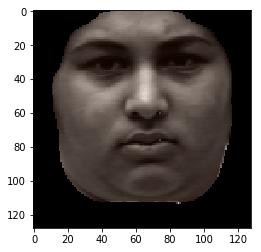

In [6]:
i=79
image, label = data[i]
plt.imshow(image)



In [7]:


def lincomb(im1,im2,mask,alpha=0.5):
    im = im1.copy()     
    row, col = np.where(mask != 0)
    for i in range( len(row) ):
        r,c = row[i],col[i]
        im[r,c,0] = im1[r,c,0]*(1-alpha) + im2[r,c,0]*(alpha)
        im[r,c,1] = im1[r,c,1]*(1-alpha) + im2[r,c,1]*(alpha)
        im[r,c,2] = im1[r,c,2]*(1-alpha) + im2[r,c,2]*(alpha)
    return im

def setcolor(im, mask, color):    
    tmp=im.copy()
    tmp=np.reshape( tmp, (-1, im.shape[2])  )   
    mask = np.reshape( mask, (-1,1))      
    tmp[ np.where(mask>0)[0] ,:] = color
    im=np.reshape( tmp, (im.shape)  )
    return im

def makecolormask( mask, color=[1,0,0] ):
    colormask = np.zeros( (mask.shape[0], mask.shape[1], 3) )    
    colormask = setcolor(colormask, mask, color )        
    return colormask



(276, 276, 3)
(276, 276, 2) 0.0 1.0


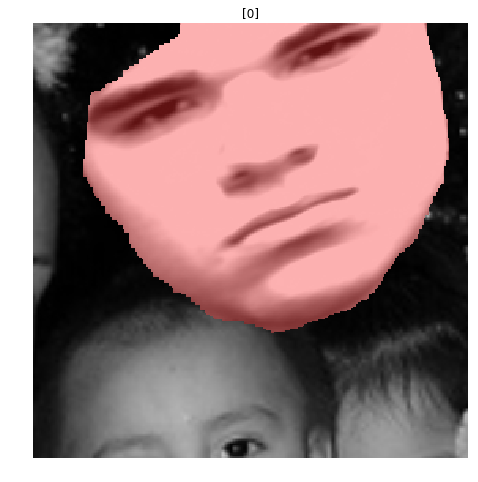

In [8]:

image, mask, label = dataset[ np.random.randint( len(dataset) )  ]   

# print(idx)
print(image.shape)
print(mask.shape, mask.min(), mask.max() )

mask = mask[:,:,1]
colormask = makecolormask( mask, color=[1,0,0] )

plt.figure( figsize=(8,8) )
plt.imshow( lincomb( image/255, colormask, mask, alpha=0.3 ) )
# plt.imshow(mask)
# plt.imshow(image)
# plt.imshow(mask, cmap='seismic', alpha=0.2)
plt.title( label )
plt.axis('off')
plt.show()



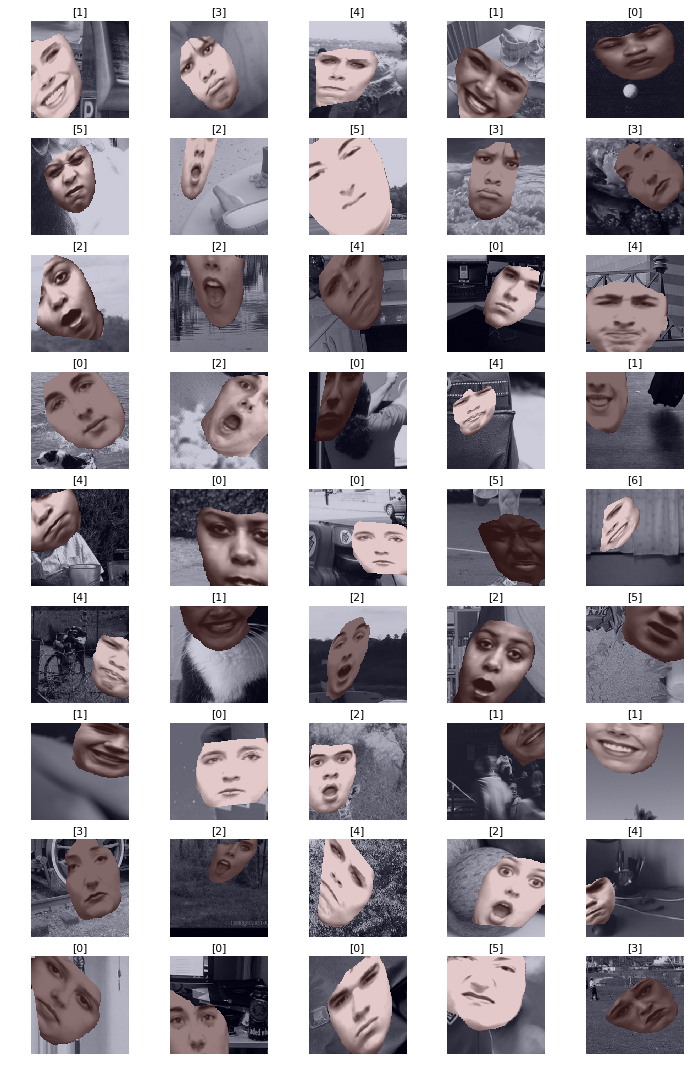

In [9]:
import matplotlib
matplotlib.rcParams['font.size'] = 9
matplotlib.rcParams['figure.figsize'] = (12,19)

numRows = 9; numCols = 5

plt.figure()
for k in range(numRows*numCols):
    image, mask, label = dataset[ np.random.randint( len(dataset) )  ]  
    plt.subplot(numRows,numCols,k+1); 
    plt.imshow( image )
    plt.imshow( mask[:,:,1], cmap='seismic', alpha=0.2)
    plt.title( label ); 
    plt.axis('off')
    

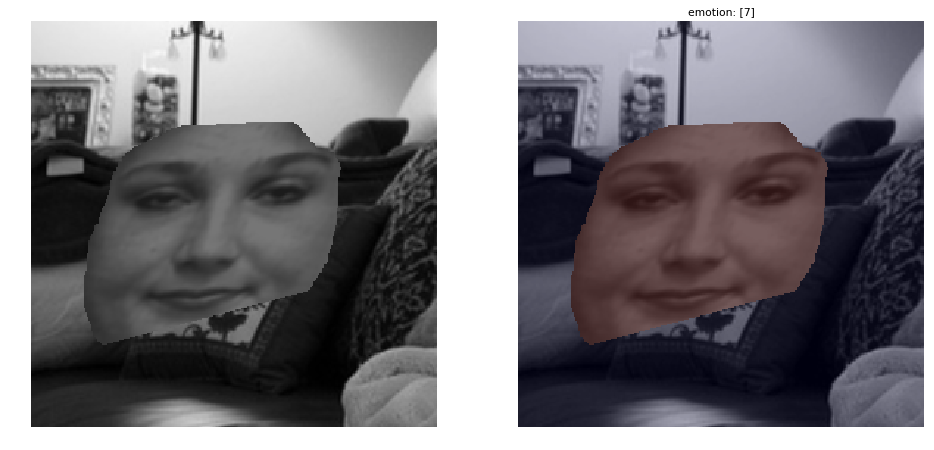

In [9]:
image, mask, label = dataset[ np.random.randint( len(dataset) )  ] 

plt.figure( figsize=(16,8) )
plt.subplot(121)
plt.imshow(image/255)
# plt.title( name )
plt.axis('off')
plt.subplot(122)
plt.imshow(image)
plt.imshow(mask[:,:,1], cmap='seismic', alpha=0.2)
plt.title( 'emotion: {}'.format(label) )
plt.axis('off')
plt.show()


In [23]:
def maggradient(image):
    gI = np.gradient(image)
    divI =  (gI[0]**2 + gI[1]**2)**0.5 
    mg  = np.sum(divI>0.001)/np.prod(divI.shape)
    return mg


In [4]:
data=FactoryDataset.factory(
    pathname=pathnamedata, 
    name=FactoryDataset.bu3dfe, 
    subset=FactoryDataset.training, 
    download=True 
    )

dataset = SyntheticFaceDataset(
    data,
    pathnameback,
    generate='image_and_mask',
    iluminate=True, angle=45, translation=0.3, warp=0.2, factor=0.2,
    transform_image=transforms.Compose([            

        mtrans.ToResize( (64,64), resize_mode='square', padding_mode=cv2.BORDER_REPLICATE), 
        #mtrans.ToRandomTransform( mtrans.VFlip(), prob=0.5 ),         
        mtrans.ToTensor(),
        mtrans.ToMeanNormalization( mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], )
        #mtrans.ToNormalization(),
        ]),
    
    transform_data=transforms.Compose([            

        mtrans.ToResize( (64,64), resize_mode='square', padding_mode=cv2.BORDER_REPLICATE), 
        #mtrans.ToRandomTransform( mtrans.VFlip(), prob=0.5 ), 
        
        mtrans.ToRandomTransform( mtrans.RandomBrightness( factor=0.30 ), prob=0.50 ),
        mtrans.ToRandomTransform( mtrans.RandomContrast( factor=0.30 ), prob=0.50 ),
        mtrans.ToRandomTransform( mtrans.RandomGamma( factor=0.30 ), prob=0.50 ),
        mtrans.ToRandomTransform( mtrans.RandomRGBPermutation(), prob=0.50 ),
        #mtrans.ToRandomTransform( mtrans.CLAHE(), prob=0.25 ),
        #mtrans.ToRandomTransform(mtrans.ToGaussianBlur( sigma=0.2 ), prob=0.50 ),
        mtrans.ToRandomTransform(mtrans.ToGaussianNoise( sigma=0.05 ), prob=0.750 ),
        
        mtrans.ToTensor(),
        mtrans.ToMeanNormalization( mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], )
        #mtrans.ToNormalization(),
        ])
)

dataloader = DataLoader(dataset, batch_size=4, shuffle=True, num_workers=4 )
print( len(dataset) )


519


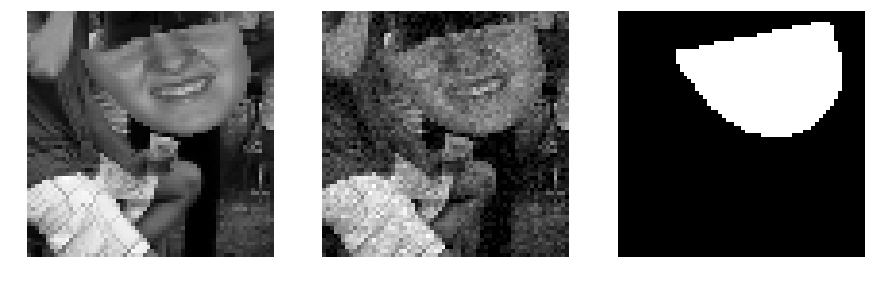

In [17]:

x_org, x_img, y_mask, y_lab = dataset[0]

orign = x_org[0,...]
image = x_img[0,...]
mask  = y_mask[1,...]

plt.figure( figsize=(15,15) )
plt.subplot(131)
plt.imshow(orign,cmap='gray')
plt.axis('off')
plt.ioff()

plt.subplot(132)
plt.imshow(image,cmap='gray')
plt.axis('off')
plt.ioff()  

plt.subplot(133)
plt.imshow(mask,cmap='gray')
plt.axis('off')
plt.ioff()      

plt.show() 


torch.Size([4, 3, 128, 128]) torch.Size([4, 2, 128, 128]) torch.Size([4, 1])


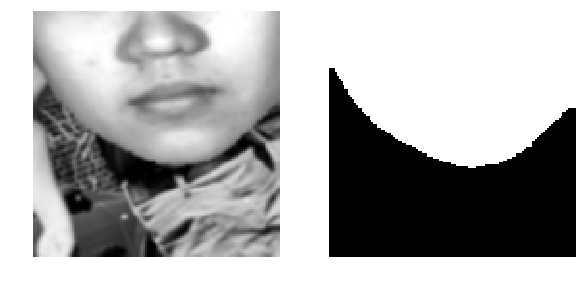

torch.Size([4, 3, 128, 128]) torch.Size([4, 2, 128, 128]) torch.Size([4, 1])


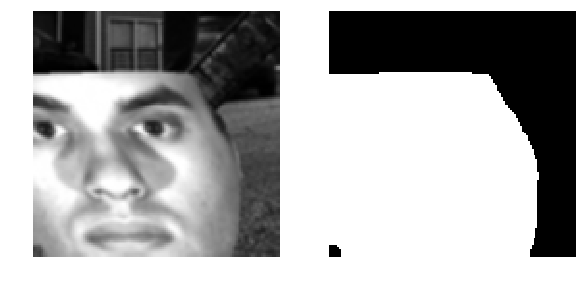

torch.Size([4, 3, 128, 128]) torch.Size([4, 2, 128, 128]) torch.Size([4, 1])


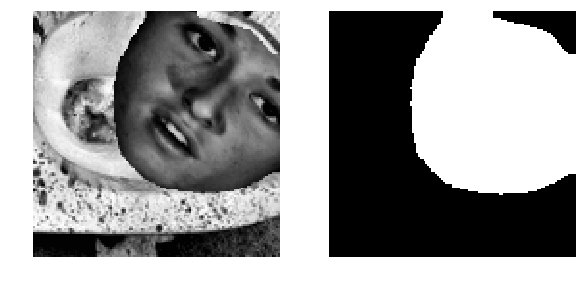

torch.Size([4, 3, 128, 128]) torch.Size([4, 2, 128, 128]) torch.Size([4, 1])


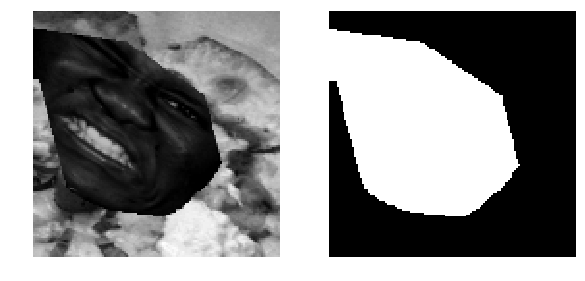

In [6]:


label_batched = []
for i_batch, (x_img, y_mask, y_lab) in enumerate(dataloader):
    print(x_img.shape, y_mask.shape, y_lab.shape)
    
    image = x_img[0,0,...]
    mask  = y_mask[0,1,...]
    
    # observe 4th batch and stop.
     
        
    plt.figure( figsize=(15,15) )
    plt.subplot(131)
    plt.imshow(image,cmap='gray')
    plt.axis('off')
    plt.ioff()

    plt.subplot(132)
    plt.imshow(mask,cmap='gray')
    plt.axis('off')
    plt.ioff()        
    plt.show()   
        
    if i_batch == 3:
        break
    
    